# MACHINE LEARNING - 'CAN YOU 'THINK' ME A HAND'  

Project Supervisor: David Wong
Link to Overleaf Report: https://www.overleaf.com/9922211613gydwmvdnwgvc

Using an ensemble of techniques to classify L/R windows of EEG activity (aswell as using ECoG data),with the option of creating visualisations to demonstrate these inferences.  


### Table of Contents

* [Section 1 - Raw Data Visulisation](#sec1)
    * [Section 1.1 Imports](#section_1_1)
    * [Section 1.2 Data Set Description & Global Variables](#section_1_2)
    * [Section 1.2 Dat Set Import](#section_1_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

### Section 1 Raw Data Visulisation <a class="anchor" id="sec1"></a>

#### 1. Imports <a class="anchor" id="section_1_1"></a>

The following section will import the modules needed for the methods used in this project.


In [1]:
# For Data Analysis
import pandas as pd 
import pyeeg
import numpy as np 
import matplotlib.pyplot as plt
import pickle

# Scipy
from scipy.fft import fft, fftfreq
import scipy.signal as signal
import pickle


# For Data Visulisation
import qgrid

from matplotlib import animation
from IPython.display import HTML

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


#### 2. Data Set Description <a class="anchor" id="section_1_2"></a>

The following section will describe the characteristics of the csv data used in this project.

##### Global variables

- FS [Sampling frequency] - number of samples (mv) taken per second = <b>250Hz</b>



In [2]:
raw_fs = 250

eeg_chans = ["C3", "Cz", "C4"]
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"]
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

#### 3. Data Explanation <a class="anchor" id="section_1_2"></a>

The data set contains 3 Folders:
    test,
    train,
    y_train_only,
    
<b>\test</b> and <b>\train</b> contain mv (millivolt) readings for each electrode. Each .csv file within these folders is named according to:    
[B][PatientNumber][SessionNumber].csv 

<b>\y_train_only</b> contains the labels which correspond to the next 4000ms after each Event Start = 1 row in the training data.

##### Raw Data Columns 

%time - The readings are given are in intervals <b> 4ms </b>.

%C3, Cz, C4, - EEG Brain signal acquisition electrode recordings, (in uV)

%EOG:ch01, %%EOG:ch02, %EOG:ch03 - Electroculogram Eye movement electrode recordings (in uV) 

%EventStart - {0,1} Corresponding to if the given time interval is the start of an MI event.






#### 4. Data Import <a class="anchor" id="section_1_2"></a>

##### Single Patient, Single session of raw milivolt data


In [4]:
# (SP) Single Patient 01, Sesssion 01, Training
df_SP = pd.read_csv("resources/data/train/B0101T.csv")
qgrid.show_grid(df_SP)

# Table showing Single Patient, Single session of raw milivoltage data

# ADD Y TRAIN

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Motor Imagery task events are marked with the <b>class 1</b> in the EventStart column. 

In this data, at time = 223556ms there is the first EventStart = 1. Converted to timepoint (index)*: (millisecond/4) == 55889. We can use the timepoint (index) to epoch the data.

*Because Trial Length: 4 seconds == 1000 timpoints (4 ms per timepoint)*

In [4]:
firstEvent_SP = df_SP[df_SP.EventStart == 1].iloc[0]
qgrid.show_grid(firstEvent_SP)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

##### Context

"Each trial started with a fixation cross and an additional short acoustic
warning tone (1 kHz, 70 ms). Some seconds later a visual cue (an arrow
pointing either to the left or right, according to the requested class) was
presented for 1.25 seconds. Afterwards the subjects had to imagine the
corresponding hand movement over a period of 4 seconds. Each trial was
followed by a short break of at least 1.5 seconds"

<cite>BCI Competition 2008</cite>

The 'Event Start' occurs after the visual que marks the start of the Motor Imagery event. I am looking at the next 4Secs/4000ms/1000timepoints from this event start (length of trial).  In order to do this we must set the boudaries for start/end in timepoint. Each event is listed as a row in y_train only with the given label associated with either Left or Right hand movements.


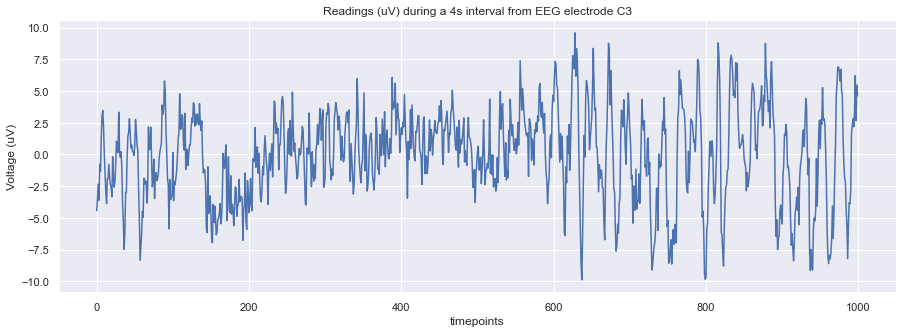

In [5]:
import seaborn as sns
sns.set()

# EEG Channel 
# Create boundaries for
first_event_SP_start = 223556 // 4
first_event_SP_end = first_event_SP_start + 1000

# Use time points as an explicit index for data
plt.figure(figsize=(15,5))
plt.plot(df_SP['C3'].values[first_event_SP_start:first_event_SP_end])
plt.title("Readings (uV) during a 4s interval from EEG electrode C3")
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()






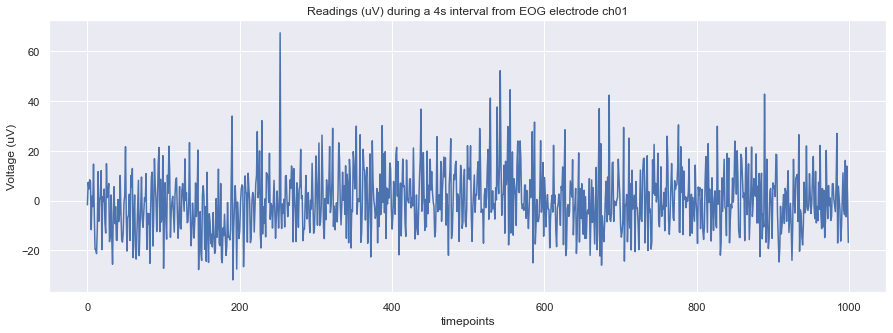

In [6]:
# EOG Channel 
# Create boundaries
first_event_SP_start = 223556 // 4
first_event_SP_end = first_event_SP_start + 1000

# Use time points as an explicit index for data
plt.figure(figsize=(15,5))
plt.plot(df_SP['EOG:ch01'].values[first_event_SP_start:first_event_SP_end])
plt.title("Readings (uV) during a 4s interval from EOG electrode ch01")
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()







#### 5. Visualizing an Epoch interval for a Single Channel (C3) with PSD vs FFT <a class="anchor" id="section_1_2"></a>

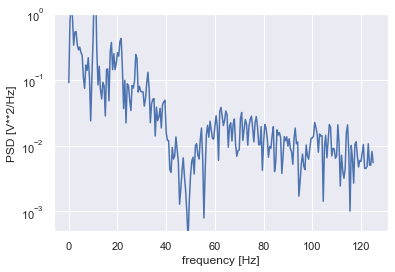

In [7]:
#### Power spectral density (Welch Method vs FFT)
#### Using Welch Method
voltage_data = df_SP['C3'].values[first_event_SP_start:first_event_SP_end]
f, Pxx_den = signal.welch(voltage_data, raw_fs, nperseg=raw_fs*2)

plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

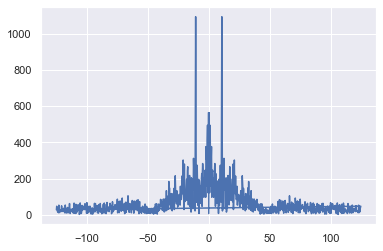

In [8]:
####  (FFT)
#### FFT Plot requires number of samples and strength values
voltage_data = df_SP['C3'].values[first_event_SP_start:first_event_SP_end]

N = 1000

yf = fft(voltage_data)
xf = fftfreq(N, 1 / raw_fs)

plt.plot(xf, np.abs(yf))
plt.show()







#### 6. Formatting the raw data by Trial : <a class="anchor" id="section_1_2"></a>


- 1. For each event (L/R) in the training labels, get the event type.
- 2. For each label i find event row i from 'EventStart' == 1 dataframe (raw data that signifies start, get the time)
- 3. Add on 4000ms to get the end time
- 4. Take a subset of the raw data within this interval
- 5. For each channel get the data within this interval, append it to eeg_dat
    Data is now in the form 
    for each epoch there is a list
        eegdat channel 1
        eegdat channel 2
        eegdat ... n
        
- 6. send epochs, labels, epoch times, channels to create df, separate the epoch channel data into a column for each channel in getDF



In [9]:
## Create DF for each of these, columns are channels, each row is a trial run
def getDF(epochs, labels, times, chans):
    data_dict = {}
    for i, label in enumerate(labels): 
        # For each epoch get the start time
        start_time = times[i][0]
        if 'start_time' not in data_dict: 
            data_dict['start_time'] = list()
        data_dict['start_time'].append(start_time)
    
        # For each epoch type add
        if 'event_type' not in data_dict:
            data_dict['event_type'] = list()
        data_dict['event_type'].append(label)
        
        # For epoch add to as a column for each channel
        for ch in range(len(chans)): 
            if chans[ch] not in data_dict:
                data_dict[chans[ch]] = list() 
            data_dict[chans[ch]].append(epochs[i][ch])
        
    return pd.DataFrame(data_dict)

# Break raw data down into epoched sections
def getEpochedDF(eeg_df, event_df, trial_duration_ms=4000):
    epochs = []
    epoch_times = []
    labels = []
    # Get all rows which are the start of a trial
    start_df = eeg_df[eeg_df['EventStart'] == 1]
    for i, event_type in enumerate(event_df["EventType"].values): 
        # Get event type label
        labels.append(event_type)
        
        # Get the start/end time of event marker
        start_time = start_df.iloc[i]["time"]
        end_time = int(start_time + trial_duration_ms)
        
        # Save the time interval
        epoch_times.append((start_time, end_time))
        
        # Get the rows between start time, before the end time
        sub_df = eeg_df[(eeg_df['time'] > start_time) & (eeg_df['time'] <= end_time)]
        eeg_dat = []
        
        # For each channel append the values to the eeg_dat list
        for ch in all_chans: 
            eeg_dat.append(sub_df[ch].values)
        
        # For each epoch append the list of data within the time interval in the order of ch1, ch2, ch3 ... chn
        epochs.append(np.array(eeg_dat))

    # Create dataframe from the data extracted previously
    eeg_epoch_df = getDF(epochs, labels, epoch_times, all_chans)
    return eeg_epoch_df

#### 7. Visuslising an Epoch Trial

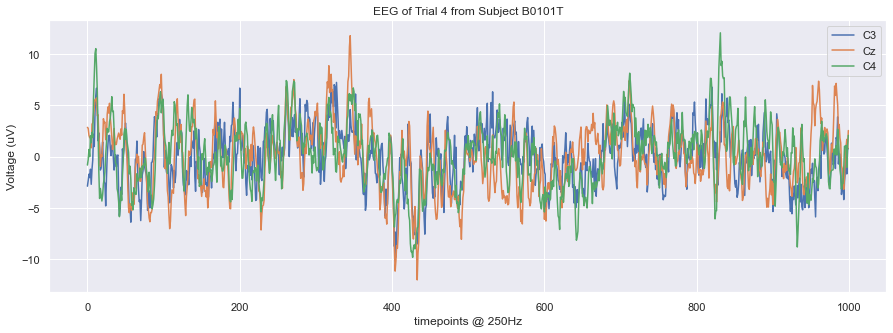

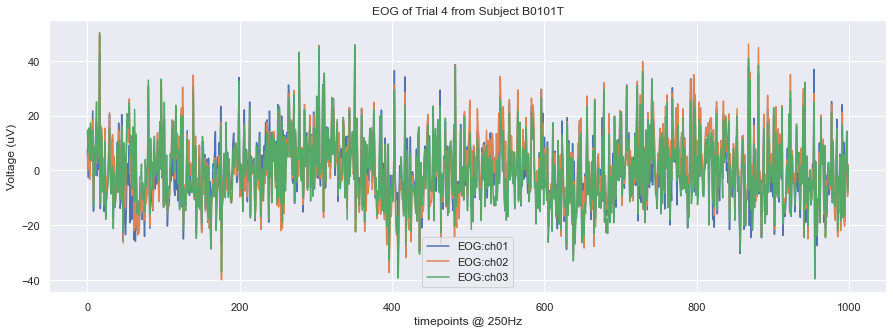

In [10]:
# Read in Y train labels
event_df = pd.read_csv("resources/data/y_train_only/B0101T.csv")

# Get a dataframe with epoched data alongside labels
eeg_epoch_df = getEpochedDF(df_SP, event_df, trial_duration_ms=4000) 


trial_number = 4

plt.figure(figsize=(15,5))
for ch in eeg_chans:
    plt.plot(eeg_epoch_df[ch][trial_number], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.legend() 
plt.title("EEG of Trial 4 from Subject B0101T")\

plt.figure(figsize=(15,5))
for ch in eog_chans: 
    plt.plot(eeg_epoch_df[ch][trial_number], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EOG of Trial 4 from Subject B0101T")
plt.legend() 
plt.show()



In [11]:
qgrid.show_grid(eeg_epoch_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### 8. Using PSD Visualisations

Creating a function for plotting PSD estimations using frequency filtering

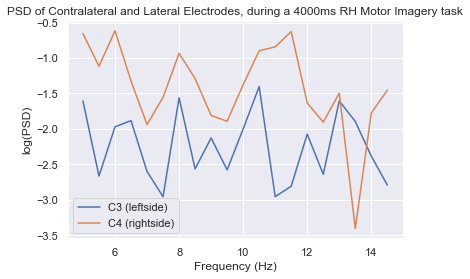

In [12]:
# Analyse visually PSD C3/C4, trial 1 from patient 1, event Type 1 (Right)

def getFilteredPSD(eeg_data, fs=raw_fs, low_cut=0, high_cut=120, label=None):
    # Use scipy's signal.periodogram to do the conversion to PSDs
    
    
    freq, psd = signal.welch(eeg_data, raw_fs, nperseg=raw_fs*2)
    
    # Label the axes
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(PSD)')
    
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    # In order to get the index point in which the frequency is cut off
    # We went the section marker that represents the ration cut off:max freq
    low_cut_idx = int(len(freq)*(low_cut / freq[-1]))
    post_cut_idx = int(len(freq)*(high_cut / freq[-1]))
    
    # Plot
    plt.plot(freq[low_cut_idx:post_cut_idx], np.log(psd[low_cut_idx:post_cut_idx]), label=label)
    plt.legend()

    

"""
'One prominent group of such brain
oscillations has frequencies between 9 – 13 Hz in man...'

Pfurtscheller G, Brunner C, Schlögl A, Lopes da Silva FH. Mu rhythm (de)synchronization and EEG single-trial classification of different motor imagery tasks. Neuroimage. 2006 May 15;31(1):153-9. doi: 10.1016/j.neuroimage.2005.12.003. Epub 2006 Jan 27. PMID: 16443377.

"""

C3_voltage_data = eeg_epoch_df['C3'][1]
C4_voltage_data = eeg_epoch_df['C4'][1]

# Check the expected class is Right movement
eeg_epoch_df['event_type'][1]

# Blue/Orange
plt.title("PSD of Contralateral and Lateral Electrodes, during a 4000ms RH Motor Imagery task")
getFilteredPSD(C3_voltage_data, raw_fs, 5, 15, 'C3 (leftside)') 
# Green
getFilteredPSD(C4_voltage_data, raw_fs, 5, 15, 'C4 (rightside)')


Evaluation of PSD (VISUAL BASED)
- The above plot shows decreased power in the leftside C3 electrode, indicating (using evidence from literature - see report) that the movement was associated with right hand movements.
- The actual event type for this was: 'event type' = 1
- Trial Type - 0 means Left, 1 means Right. 
- Visual inference of Correct class.


0


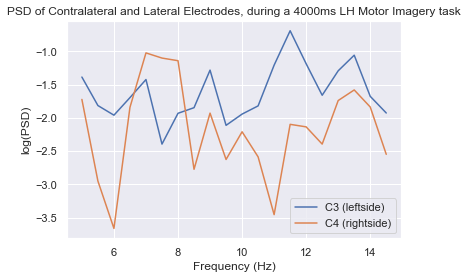

In [13]:
# Analyse visually PSD C3/C4, trial 3 from patient 1, event Type 0 (Left)

C3_voltage_data = eeg_epoch_df['C3'][2]
C4_voltage_data = eeg_epoch_df['C4'][2]

# Check the expected class is Left movement
print(eeg_epoch_df['event_type'][2])

# Blue/Orange
plt.title("PSD of Contralateral and Lateral Electrodes, during a 4000ms LH Motor Imagery task")
getFilteredPSD(C3_voltage_data, raw_fs, 5, 15, 'C3 (leftside)') 
# Green
getFilteredPSD(C4_voltage_data, raw_fs, 5, 15, 'C4 (rightside)')

Evaluation of PSD (VISUAL BASED)
- The above plot shows decreased power in the rightside C4 electrode, movement was associated with left hand movements.
- The actual event type for this was: 'event type' = 0 (left)
- Visual inference of Correct class.

### Section 2 Feature extraction <a class="anchor" id="sec2"></a>
#### 2.1 Power Ratio <a class="anchor" id="sec2"></a>

    The integral of the PSD over a given frequency band computes the average power in the signal over that frequency band. This value is then normalised to give a power ratio by dividing by total power. 

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.output_result { max-width:10% !important; }</style>"))

# Compute power in each frequency bin specified by Band from FFT result of X. 
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    # This method will return the Powers for bins (List) (Integral of PSD). And the Power_ratio spectral power in each frequency bin normalized by total power in ALL frequency bins.
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    
    return np.array(power_ratio)

def convertBintoIntervals(bins): 
    intervals = list()
    for i, val in enumerate(bins[:-1]): 
        intervals.append((val, bins[i+1]))
    return intervals


# Produces a N(epochs) Size dataframe which contains raw Channel data, and channel ratios
def getPowerRatioFeatures(eeg_data, power_bins, intervals, raw_fs=250):
    number_of_trials = eeg_data.shape[0]
    # For each trial
    power_ratios_df = pd.DataFrame()
    
    for trial in range(number_of_trials):
        event_type = eeg_data['event_type'][trial]
        # For each electrode, calculate power bins
        trial_df = pd.DataFrame()
        # For each channel get the power bins
        for ch in eeg_chans: 
            power_ratios = getPowerRatio(eeg_data[ch][trial][:], power_bins, raw_fs)
            column_headers = []
            # For each interval create a header relating the channel
            for index in intervals:
                header = ch + str(index)
                column_headers.append(header)
                
            # Store the data for this channel, all the power ratios
            channel_df = pd.DataFrame([power_ratios])
            # Name the columns
            channel_df.columns = column_headers
            
            # Add data to tuple for current trial
            trial_df = pd.concat([trial_df, channel_df], axis=1)
        
        # Add Power ratios for each electrode to dataframe
        power_ratios_df = power_ratios_df.append(trial_df, ignore_index=True)

    return power_ratios_df

              

# Get the power bin features
power_bins = [0.5,4,7,12,30]
intervals = convertBintoIntervals(power_bins)
power_ratio_features_subject01 = getPowerRatioFeatures(eeg_epoch_df, power_bins, intervals, raw_fs)
print(power_ratio_features_subject01)

# Analyse Quantified Power Ratios C3/C4, trial 1 from patient 1, event Type 1 (Right)
# For trial 0 I expect a relationship (Left Power < Right Power) otherwise known as (C3(7,12)) < (C4(7,12)) 
C3_mu_power = power_ratio_features_subject01['C3(7, 12)'][1]
C4_mu_power = power_ratio_features_subject01['C4(7, 12)'][1]

if (C3_mu_power <  C4_mu_power):
    print('Left electrode detected decrease of power in Mu Rhythm freq range (7-12Hz)')
    C3_diff = (C3_mu_power - C4_mu_power)
    print('Normalized power ratio of C3 (Left) difference = ' + str(C3_diff))

# Does this confirm my preliminary test of trials/epochs 1/2?
#  --- Yes

# Analyse Quantified Power Ratios C3/C4, trial 2 from patient 1, event Type 0 (Left)
# For trial 0 I expect a relationship (Left Power < Right Power) otherwise known as (C3(7,12)) < (C4(7,12)) 
C3_mu_power = power_ratio_features_subject01['C3(7, 12)'][2]
C4_mu_power = power_ratio_features_subject01['C4(7, 12)'][2]

if (C4_mu_power <  C3_mu_power):
    print('Right electrode detected decrease of power in Mu Rhythm freq range (7-12Hz)')
    C4_diff = (C4_mu_power - C3_mu_power)
    print('Normalized power ratio of C4 (Right) difference = ' + str(C4_diff))

# Does this confirm my preliminary test of trials/epochs 1/2?
#  --- Yes



     C3(0.5, 4)  C3(4, 7)  C3(7, 12)  C3(12, 30)  Cz(0.5, 4)  Cz(4, 7)  \
0      0.190380  0.103543   0.240617    0.465460    0.183383  0.098315   
1      0.338060  0.081168   0.118130    0.462642    0.238569  0.106955   
2      0.234302  0.101459   0.162443    0.501796    0.191182  0.157964   
3      0.247263  0.139796   0.177430    0.435511    0.316947  0.093709   
4      0.249109  0.107688   0.202389    0.440814    0.189605  0.109879   
..          ...       ...        ...         ...         ...       ...   
115    0.196299  0.063880   0.252013    0.487807    0.241848  0.086776   
116    0.215619  0.104352   0.203989    0.476040    0.221922  0.092710   
117    0.206666  0.107449   0.264173    0.421712    0.221054  0.114098   
118    0.294929  0.084257   0.184013    0.436801    0.208896  0.098898   
119    0.217350  0.121841   0.228415    0.432394    0.175000  0.096339   

     Cz(7, 12)  Cz(12, 30)  C4(0.5, 4)  C4(4, 7)  C4(7, 12)  C4(12, 30)  
0     0.310271    0.408030    0.17644

#### 2.2 Instantanous Amplitude <a class="anchor" id="sec2"></a>

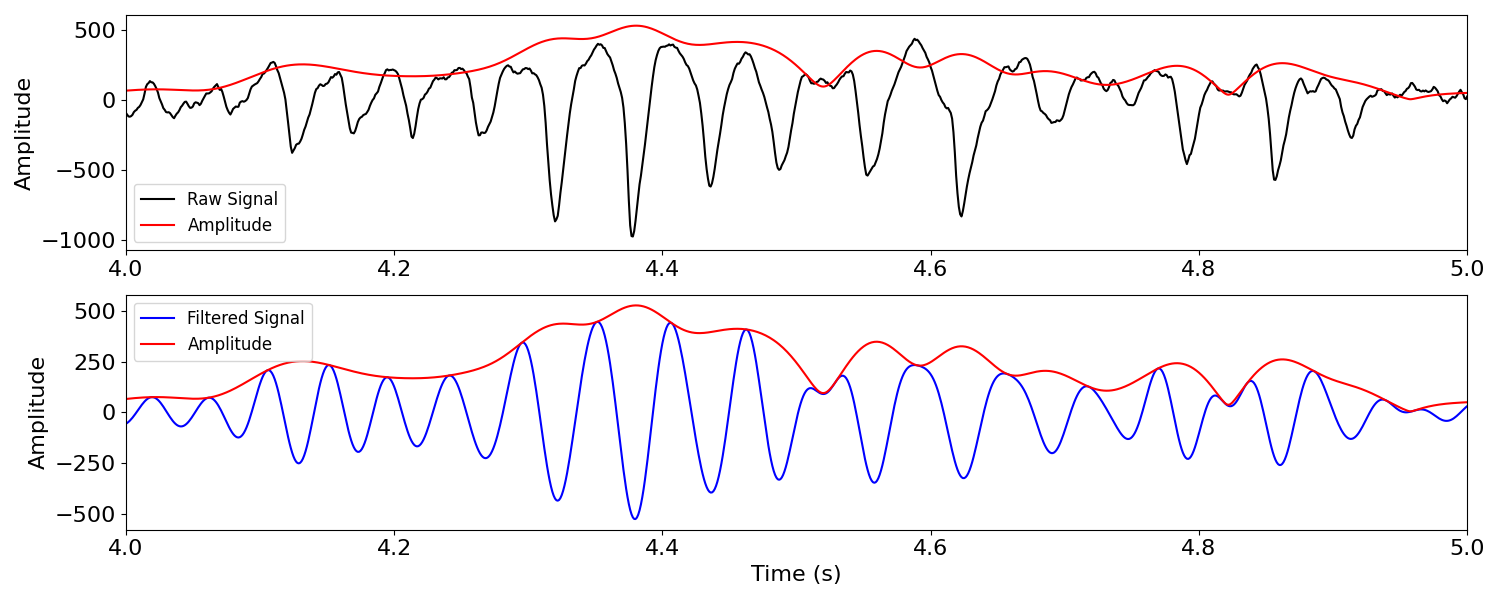

##### Image from https://neurodsp-tools.github.io/

In [15]:
# Produces a N(epochs) Size dataframe which contains raw Channel data, and channel ratios
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time # For neurodsp features

def getInstantaneousAmpFeatures(eeg_data, raw_fs=250):
    number_of_trials = eeg_data.shape[0]
    # For each trial
    inst_amp_df = pd.DataFrame()
    
    for trial in range(number_of_trials):
        event_type = eeg_data['event_type'][trial]
        # For each electrode, calculate power bins
        trial_df = pd.DataFrame()
        # For each channel get the power bins
        for ch in eeg_chans: 
            # Calculate the amp_median
            amp = amp_by_time(eeg_data[ch][trial][:], raw_fs, (7, 12))
            amp_median = np.nanmedian(amp)
            amp_data = [[amp_median]]
            
            column_headers = []
            # For each interval create a header relating the channel
            header = ch + '_inst_Amp'

            # Create the pandas DataFrame
            channel_df = pd.DataFrame(amp_data, columns =[header])
            
            # Add data to tuple for current trial
            trial_df = pd.concat([trial_df, channel_df], axis=1)
        
        # Add Power ratios for each electrode to dataframe
        inst_amp_df = inst_amp_df.append(trial_df, ignore_index=True)

    return inst_amp_df

inst_amp_features_subject01 = getInstantaneousAmpFeatures(eeg_epoch_df)


### Section 3 Experiment 1  SciKit Learn Classifiers <a class="anchor" id="sec3"></a>

#### Section 3.1.1 Combine Features  <a class="anchor" id="sec3"></a>

In [16]:
# Combine Inst & PSD
# Get a list of CSVs
import os
subjects = os.listdir('resources/data/train')
if '.DS_Store' in subjects:
    subjects.remove('.DS_Store')
    
    
combined_feature_vector = pd.DataFrame()

for subject in subjects:
    # Raw voltage for subject
    path = "resources/data/train/" + str(subject)
    subject_df = pd.read_csv(path)
    
    # Labels for subject
    path = "resources/data/y_train_only/" + str(subject)
    event_df = pd.read_csv(path)

    # Epoch the data
    eeg_epoch_df = getEpochedDF(subject_df, event_df, trial_duration_ms=4000) 
    
    # Get subject Label
    subject_name = subject[:-4]
    subject_dict = {'subject_id': [subject_name]}
    subject_name_df = pd.DataFrame(data=subject_dict)
    
    # Combine Features
    inst_amp_features_subject01 = getInstantaneousAmpFeatures(eeg_epoch_df)
    power_ratio_features_subject01 = getPowerRatioFeatures(eeg_epoch_df, power_bins, intervals, raw_fs)
    features_vector_subject01 = pd.concat([power_ratio_features_subject01, inst_amp_features_subject01], axis=1)
    features_vector_subject01 = pd.concat([features_vector_subject01, eeg_epoch_df['event_type']], axis=1)
    
    # Add subject Labels
    features_vector_subject01 = pd.concat([subject_name_df, features_vector_subject01], axis=1)
    features_vector_subject01.loc[:, 'subject_id'] = str(subject_dict['subject_id'][0])
    
    combined_feature_vector = combined_feature_vector.append(features_vector_subject01)
    
qgrid.show_grid(combined_feature_vector)




QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Section 3.1.2 Split Data  <a class="anchor" id="sec3"></a>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Split data into training and test sets
train_features = combined_feature_vector[:-1][:]
print(train_features)
train_features = combined_feature_vector.drop(columns=["subject_id", "event_type"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(train_features, combined_feature_vector["event_type"])
x_train.shape, x_test.shape
train_features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

    subject_id  C3(0.5, 4)  C3(4, 7)  C3(7, 12)  C3(12, 30)  Cz(0.5, 4)  \
0       B0103T    0.264700  0.094814   0.192619    0.447866    0.266806   
1       B0103T    0.277281  0.115122   0.160934    0.446663    0.270500   
2       B0103T    0.226393  0.155244   0.212073    0.406290    0.188782   
3       B0103T    0.243446  0.119034   0.156167    0.481353    0.200337   
4       B0103T    0.234411  0.122240   0.183082    0.460267    0.254907   
..         ...         ...       ...        ...         ...         ...   
114     B0602T    0.184909  0.172007   0.283069    0.360015    0.214451   
115     B0602T    0.253859  0.139904   0.255099    0.351138    0.241943   
116     B0602T    0.310690  0.157243   0.225669    0.306398    0.251570   
117     B0602T    0.321658  0.094182   0.276631    0.307528    0.323861   
118     B0602T    0.272066  0.131705   0.277949    0.318280    0.240214   

     Cz(4, 7)  Cz(7, 12)  Cz(12, 30)  C4(0.5, 4)  C4(4, 7)  C4(7, 12)  \
0    0.136653   0.169808  

#### Section 3.1.3 Feature Scaling (SciKit Learn) 

##### Feature Scaling - an improvement

Before scaling the values for the following classifiers 3.2.* were less accurate on all accounts.

 
##### Logistic Regression

Before Scaling
- Training Accuracy: 0.690580
- Testing Accuracy: 0.654348

After Scaling
- Training Accuracy: 0.6880434782608695
- Testing Accuracy: 0.6728260869565217


<b> Decision Trees </b>

Training Accuracy: 1.0
Testing Accuracy: 0.6021739130434782

Before Scaling
- Training Accuracy: 1.000000
- Testing Accuracy: 0.569565

After Scaling
- Training Accuracy: 1.0
- Testing Accuracy: 0.6021739130434782

<b> SVM </b>

Before Scaling

'rbf' Kernel
- Training Accuracy: 0.669928
- Testing Accuracy: 0.665217

'polynomial' kernel
- Training Accuracy: 0.678261
- Testing Accuracy: 0.660870

'linear' kernel
- Training Accuracy: 0.686594
- Testing Accuracy: 0.665217

After Scaling

'rbf' Kernel
- Training Accuracy: 0.746014
- Testing Accuracy: 0.695652

'polynomial' kernel
- Training Accuracy: 0.716667
- Testing Accuracy: 0.670652

'linear' kernel
- Training Accuracy: 0.690942
- Testing Accuracy: 0.668478

##### - Overall all classifiers were more accurate after scaling the input features. Scaling occurs so that The features with high magnitude will weigh in equally relative to those with low magnitude Scikit, uses standardization which works by removing the mean and scaling to unit variance.

#### Section 3.2.1 Logistic Regression (SciKit Learn)  <a class="anchor" id="sec3"></a>

In [18]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(x_train, y_train)
train_preds = logistic_regression_model.predict(x_train)
test_preds = logistic_regression_model.predict(x_test)
print("Training Accuracy: " + str(accuracy_score(train_preds, y_train)))
print("Testing Accuracy: " + str(accuracy_score(test_preds, y_test)))

# Get the values representing distance from decision boundary
y_pred_logreg = logistic_regression_model.decision_function(x_test)

Training Accuracy: 0.6855072463768116
Testing Accuracy: 0.683695652173913


Logistic Regression calculates the class output for each trial by passing the features through a prediction function and returning a probability score between 0 and 1. A threshold, .5 for binary classification is used to determine the class label.

Each solver used in logistic regression tries to find the parameter weights that minimize a cost function using cross entropy loss and gradient descent variations. Cross entropy loss explains the difference of probabilities from the actual label, the same values used for ROC analysis to evaluate tp/fp rate over a varying threshold.

Specifically the Scikit implementation uses by default L-BFGS-B – Software for Large-scale Bound-constrained Optimization in order to optimise the weights during training. 

Alternative ‘solvers’ available via the scikit implementation of logistic regression such as SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives yielded results of:

- Training Accuracy: 0.6880434782608695
- Testing Accuracy: 0.6728260869565217

1. Overfitting is sparse due to similar accuracies for testing/training.


#### Section 3.2.2 Decision Tree (SciKit Learn)  <a class="anchor" id="sec3"></a>

In [19]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(x_train, y_train)
train_preds = dtree_model.predict(x_train)
test_preds = dtree_model.predict(x_test)
print("Training Accuracy: " + str(accuracy_score(train_preds, y_train)))
print("Testing Accuracy: " + str(accuracy_score(test_preds, y_test)))

# Get the values representing distance from decision boundary
y_pred_dtree = dtree_model.predict_proba(x_test)

Training Accuracy: 1.0
Testing Accuracy: 0.6326086956521739


Decision trees create multiple decision boundaries in order to classify data input. These boundaries are represented by constructing a series of decision nodes called branches, which partition data points during training. The data is separated until a final classification node, called a leaf node, which determines the data label.

Decision trees are constructed in a way to maximise information gain/the most homogeneous branches at each level of the branch. ‘Pruning’ refers to shortening of branches, which simplifies the decision tree and can avoid overfitting, which trees are prone too. This is because the structure of the tree can become overly complex and suited to the training data, but not new values.

As mentioned in the implementation documentation ‘Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting.’  Overfitting has been evidenced in this case with training accuracy = 1.0.


- Training Accuracy: 1.0
- Testing Accuracy: 0.6021739130434782

1. The decision tree is overly complex in regards to overfitting the training data (100% accuracy). 
2. This pruning technique is parameterized by the cost complexity parameter, therefore adjustment of this Hyper parameter may improve the decision trees performance for this classification task (shown below)


Pruning the Decision Tree Model, to investigate if the model can be reduced to overfit less

- N.B Pruning was done to the 15 (Power ratios, and Instantanous Amplitude) type input feature vector 
- The parameter values used are ccp_alpha, As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.
- clf.cost_complexity_pruning_path allows an estimate of what alpha value to limited to, as it shows the alpha values at each level
- Since higher values of alpha will prune the tree more, we are looking for a maximum value of alpha that will maintain lower impurity of leaves




Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

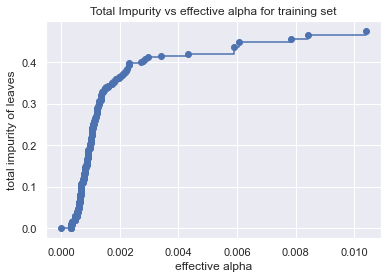

In [20]:
path = dtree_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


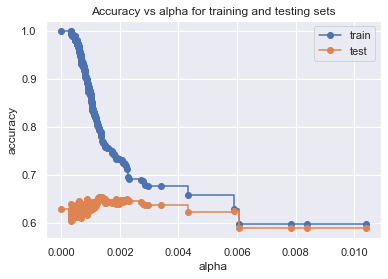

In [21]:
dtrees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtree_model = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dtree_model.fit(x_train, y_train)
    dtrees.append(dtree_model)
    
# Remove the tree with one node (where alpha max is max)

dtrees = dtrees[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [dtree.score(x_train, y_train) for dtree in dtrees]
test_scores = [dtree.score(x_test, y_test) for dtree in dtrees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [22]:
dtree_model = DecisionTreeClassifier(ccp_alpha=.002)
dtree_model.fit(x_train, y_train)
train_preds = dtree_model.predict(x_train)
test_preds = dtree_model.predict(x_test)
print("Training Accuracy: " + str(accuracy_score(train_preds, y_train)))
print("Testing Accuracy: " + str(accuracy_score(test_preds, y_test)))


Training Accuracy: 0.7333333333333333
Testing Accuracy: 0.6391304347826087


#### Section 3.2.2.1 Decision Tree with optimum Pruning (max alpha paramater) (SciKit Learn)  <a class="anchor" id="sec3"></a>

- The testing accuracy is highest at alpha value .002
- Therefore the model generalises to new data when the classifier is trained with ccp_alpha=0.002.


- Training Accuracy: 0.6942028985507246
- Testing Accuracy: 0.6282608695652174

The testing accuracy increased from  0.6054347826086957 to 0.6282608695652174.

#### Section 3.2.3 Support Vector Machine (SciKit Learn)  <a class="anchor" id="sec3"></a>

In [23]:
svc_model_rbf = SVC(kernel='rbf')
svc_model_rbf.fit(x_train, y_train)
train_preds = svc_model_rbf.predict(x_train)
test_preds = svc_model_rbf.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

# Get the values representing distance from decision boundary
y_pred_svm = svc_model_rbf.decision_function(x_test)

Training Accuracy: 0.751449
Testing Accuracy: 0.685870


In [24]:
svc_model_poly = SVC(kernel='poly')
svc_model_poly.fit(x_train, y_train)
train_preds = svc_model_poly.predict(x_train)
test_preds = svc_model_poly.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.714493
Testing Accuracy: 0.678261


In [25]:
svc_model_lin = SVC(kernel='linear')
svc_model_lin.fit(x_train, y_train)
train_preds = svc_model_lin.predict(x_train)
test_preds = svc_model_lin.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

Training Accuracy: 0.684058
Testing Accuracy: 0.693478


Support vector machines design a hyper-planes to separate input data within a space. 

Support vectors are critical elements of the training data, which are hard to classify as they are closest to the opposite class. They are selected and become the points found closest to a decision boundary and will determine (hence support the boundary) the weights for mapping new data.


The optimum hyper plane maximises the  margin between the hyperplane and the closest point within the training set.

A softmargin can allow for classification errors. However, when there is no clear hyperplane, the data points are mapped onto a higher dimensional feature space. The kernel trick returns the dot product of transformed vectors in the higher dimensional space. 

1. Linear kernels create a classification boundary in aim to separate the data with a single line, using a boundary with that segments a space with the dimensionality of the feature vector.

2. Polynomial kernel also uses the original feature vectors but also combines features to create interaction features to map the data using a finite polynomial. 


3. RBF kernels generate new features by measuring the distance between all other dots to a specific dot/dots — centers and can map the data points to an infinitely higher dimensional space.

Hyper-parameters for an SVM model C, and Gamma control the adjustment of the decision boundary in SVM.

Larger values of C produce a smaller margin, which may decrease classification error. However a larger margin will avoid overfitting (the reason why the optimal hyperplane is at the maximum distance from the opposing classes. 

Gamma, defines the influence of a single training example
Low gamma values mean a larger radius of the area of influence which results in more points being clustered together. In the case of high gamma values, the model may overfit as training examples to create boundaries beyond the original training data location.


SVM's are suitable for high dimensional data, and non linearly separable data. Scikits implementation employs Kernel formation as ‘rbf’ by default which created multidimensional decision boundaries returning accuracies of:


##### After Feature Scaling

'rbf' Kernel
- Training Accuracy: 0.746014
- Testing Accuracy: 0.695652

'polynomial' kernel
- Training Accuracy: 0.716667
- Testing Accuracy: 0.670652

'linear' kernel
- Training Accuracy: 0.690942
- Testing Accuracy: 0.668478




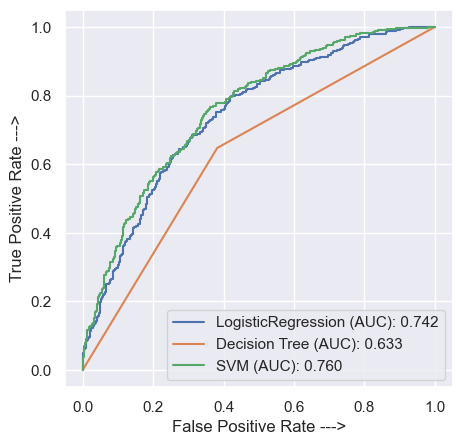

In [26]:
# ROC To compare Logistic Regression // Decision Tree // Support Vector Machines
# Plot decision functions, 
# ROC is the relationship between true positive rate and false positve rate
from sklearn.metrics import roc_curve, auc

# For Logistic Regression
logreg_fpr, logreg_tpr, logreg_threshold = roc_curve(y_test, y_pred_logreg)
auc_logreg = auc(logreg_fpr, logreg_tpr)


# For Decision tree
dtree_fpr, dtree_tpr, dtree_threshold = roc_curve(y_test, y_pred_dtree[:,1])
auc_dtree = auc(dtree_fpr, dtree_tpr)

# For SVM
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

# Visualise
plt.figure(figsize=(5,5), dpi=100)
plt.plot(logreg_fpr, logreg_tpr, linestyle='-', label='LogisticRegression (AUC): %0.3f' % auc_logreg)
plt.plot(dtree_fpr, dtree_tpr, linestyle='-', label='Decision Tree (AUC): %0.3f' % auc_dtree)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (AUC): %0.3f' % auc_svm)


plt.xlabel('False Positive Rate --->')
plt.ylabel('True Positive Rate --->')
plt.legend()

plt.show()


#### Section 3.2.6 Using Grid Search to Improve SVM <a class="anchor" id="sec3"></a>

To Optimize Parameters I have used:

- Grid Optimization


Initial Gamma: 0.06666666666666667
Initial C: 1.0
Grid Searching
Optimized Gamma and C:
SVC(C=2.75, gamma=0.1)
Training Accuracy: 0.809420
Testing Accuracy: 0.709783


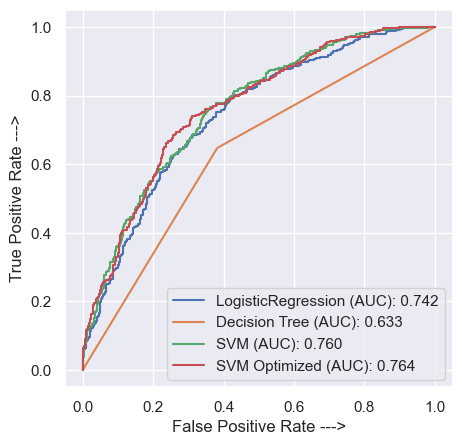

In [27]:
# Parameter C will vary the Margin size of the hyperplanes (C Inversely proportional to margin size)
# Parameter G governs the influence of a single training example (G Inversely proportional to how far)
# Information from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
from sklearn.model_selection import GridSearchCV

# Get Values created in First SVC instance
print('Initial Gamma: ' + str(svc_model_rbf._gamma))
print('Initial C: ' + str(svc_model_rbf.C))
print("Grid Searching")


svm_cv = GridSearchCV(svc_model_rbf, scoring='accuracy',
                          param_grid={'C': [0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25], 'gamma': [0.06666666666666667, 0.07, 0.08, 0.09, 0.1, 0.11, 0.05, 0.04, 0.03, 0.02, 0.01], 'kernel':['rbf']})
svm_cv.fit(x_train, y_train)
optimized_svm = svm_cv.best_estimator_
print("Optimized Gamma and C:")
print(optimized_svm)

train_preds = optimized_svm.predict(x_train)
test_preds = optimized_svm.predict(x_test)
print("Training Accuracy: %f" % accuracy_score(train_preds, y_train))
print("Testing Accuracy: %f" % accuracy_score(test_preds, y_test))

y_pred_svm_optimized = optimized_svm.decision_function(x_test)



# For Logistic Regression
logreg_fpr, logreg_tpr, logreg_threshold = roc_curve(y_test, y_pred_logreg)
auc_logreg = auc(logreg_fpr, logreg_tpr)

# For Decision tree
dtree_fpr, dtree_tpr, dtree_threshold = roc_curve(y_test, y_pred_dtree[:,1])
auc_dtree = auc(dtree_fpr, dtree_tpr)

# For SVM
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

# For SVM Optimized values
svm_opt_fpr, svm_opt_tpr, svm_opt_threshold = roc_curve(y_test, y_pred_svm_optimized)
auc_svm_opt = auc(svm_opt_fpr, svm_opt_tpr)

# Visualise
plt.figure(figsize=(5,5), dpi=100)
plt.plot(logreg_fpr, logreg_tpr, linestyle='-', label='LogisticRegression (AUC): %0.3f' % auc_logreg)
plt.plot(dtree_fpr, dtree_tpr, linestyle='-', label='Decision Tree (AUC): %0.3f' % auc_dtree)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (AUC): %0.3f' % auc_svm)
plt.plot(svm_opt_fpr, svm_opt_tpr, linestyle='-', label='SVM Optimized (AUC): %0.3f' % auc_svm_opt)

plt.xlabel('False Positive Rate --->')
plt.ylabel('True Positive Rate --->')
plt.legend()

plt.show()




### Section 3 Experiment 2  Neural Network & CNN <a class="anchor" id="sec3"></a>

#### Section 4.1.1 Augment Data  <a class="anchor" id="sec3"></a>

In [3]:
train_df = pickle.load(open("resources/epoched_train.pkl", "rb"))
train_df.head()
print(train_df.shape)

(3680, 9)


#### Section 4.1.2 Filter Data  <a class="anchor" id="sec3"></a>

In [8]:
from scipy.signal import butter, filtfilt
def fir_bandpass_filter(data, lowcut, highcut, sample_rate):
    '''
    Returns bandpass filtered data between the frequency ranges specified in the input.
    Args:
        data (numpy.ndarray): array of samples. 
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): order of the bandpass filter.
    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''

    # Modified CSP, or Mu, or blank for CSP
    lowcut = 1
    highcut = 30
    
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    order = 6
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    
    return y

In [9]:
def get_filtered_single(data, lowcut, highcut):
    fs = 250
    output_df = data
    data = data.head(1)
    
    # For each row filter the data and save as dataframe
    for count, trial in enumerate(data.iterrows()):
        trial_data = trial[1]
        # Extract Raw data
        trial_C3 = trial_data['C3']
        trial_Cz = trial_data['Cz']
        trial_C4 = trial_data['C4']
        
        # Filter Each Channel/Electrode
        filt_C3 = fir_bandpass_filter(trial_C3, lowcut, highcut, fs)
        filt_Cz = fir_bandpass_filter(trial_Cz, lowcut, highcut, fs)
        filt_C4 = fir_bandpass_filter(trial_C4, lowcut, highcut, fs)
        
        print('trial')
        #print(trial_C4)
        
        print('filt')
        #print(filt_C4)
        
        
        
    return trial_C4, filt_C4

Checking the filter is working

trial
filt


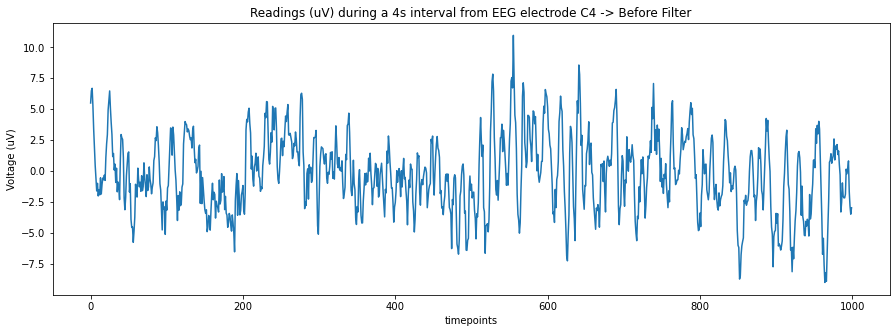

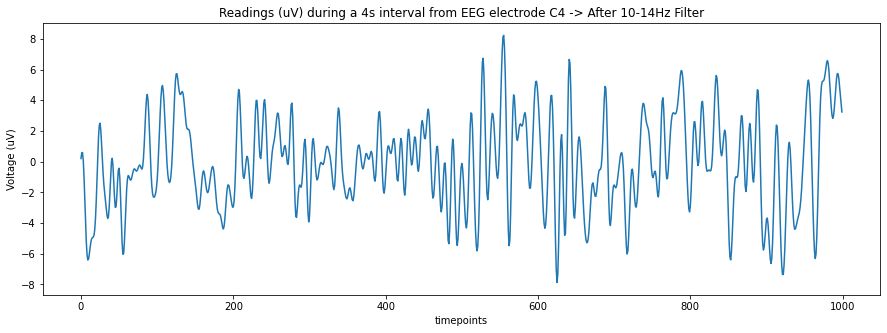

In [10]:

raw_C4, filt_C4 = get_filtered_single(train_df, 10, 14)
        
# Replace the Original Data frame
plt.figure(figsize=(15,5))
plt.plot(raw_C4)
plt.title("Readings (uV) during a 4s interval from EEG electrode C4 -> Before Filter")
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()


# Replace the Original Data frame
plt.figure(figsize=(15,5))
plt.plot(filt_C4)
plt.title("Readings (uV) during a 4s interval from EEG electrode C4 -> After 10-14Hz Filter")
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()



For every trial, filter all the channels.

In [11]:
def get_filtered_df(data, lowcut, highcut):
    """ Input: dataframe & band params and 
        Output: returns each row in a new dataframe, where each channel was filtered"""
    
    fs = 250
    output_df = data
    output_df = output_df

    
    # For each row filter the data and save as dataframe
    for count, trial in enumerate(output_df.iterrows()):
        
        # Extract Raw data
        # Get the object trial[1] that holds all the channel data etc
        trial_data = trial[1]
        
        # Extract separate channels
        trial_C3 = trial_data['C3']
        trial_Cz = trial_data['Cz']
        trial_C4 = trial_data['C4']
        
        # Filter Each Channel/Electrode
        filt_C3 = fir_bandpass_filter(trial_C3, lowcut, highcut, fs)
        filt_Cz = fir_bandpass_filter(trial_Cz, lowcut, highcut, fs)
        filt_C4 = fir_bandpass_filter(trial_C4, lowcut, highcut, fs)
        
        # Replace with filtered data
        trial_data['C3'] = filt_C3
        trial_data['Cz'] = filt_Cz
        trial_data['C4'] = filt_C4
        
        output_df['C3'].iloc[count] = trial_data['C3']
        output_df['Cz'].iloc[count] = trial_data['Cz']
        output_df['C4'].iloc[count] = trial_data['C4']
     
    return output_df

In [12]:
full_train_df = train_df
raw_train_df = full_train_df.drop(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], axis=1)

In [13]:
# Create the filtered version
# filt_train_df = get_filtered_df(train_df, 1, 20)

#
df_optfilters = pd.read_csv("resources/optimum_filters.csv")

list_patients = train_df['patient_id'].tolist()
list_patients = list(dict.fromkeys(list_patients))
filtered_train_df = pd.DataFrame(data=None)

# For each Subjects Trial
for count, patient in enumerate(list_patients):
    print('Preparing Data from Patient:' + patient)
    
    #  Get the data for that subject
    patient_df = raw_train_df[raw_train_df["patient_id"] == patient] #String
    
    # Get the opt filter
    patient_idx = int(patient[2]) - 1
    opt_filter = int(df_optfilters.iloc[patient_idx]['lcut'])
    
    # Filter the data for that patient
    # print(patient_df)
    # To restore to default change to opt filter 1, and 30 Hz
    patient_df_filtered = get_filtered_df(patient_df, opt_filter, opt_filter+4)
    #patient_df_filtered = get_filtered_df(patient_df, 8, 12)
    
    # Add to dataframe
    filtered_train_df = pd.concat([filtered_train_df, patient_df_filtered])

# print(filtered_train_df)
# print(filtered_train_df.shape)



Preparing Data from Patient:B0101T


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Preparing Data from Patient:B0102T
Preparing Data from Patient:B0103T
Preparing Data from Patient:B0201T
Preparing Data from Patient:B0202T
Preparing Data from Patient:B0203T
Preparing Data from Patient:B0301T
Preparing Data from Patient:B0302T
Preparing Data from Patient:B0303T
Preparing Data from Patient:B0401T
Preparing Data from Patient:B0402T
Preparing Data from Patient:B0403T
Preparing Data from Patient:B0501T
Preparing Data from Patient:B0502T
Preparing Data from Patient:B0503T
Preparing Data from Patient:B0601T
Preparing Data from Patient:B0602T
Preparing Data from Patient:B0603T
Preparing Data from Patient:B0701T
Preparing Data from Patient:B0702T
Preparing Data from Patient:B0703T
Preparing Data from Patient:B0801T
Preparing Data from Patient:B0802T
Preparing Data from Patient:B0803T
Preparing Data from Patient:B0901T
Preparing Data from Patient:B0902T
Preparing Data from Patient:B0903T


#### Section 4.1.3 Separate Train/Test Data <a class="anchor" id="sec3"></a>


In [14]:
# All trials will be (1000 X 3 x 1)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader


# Parameters
# Batch size, number of training samples in each pass, there is a total 3680
batch_size = 256

# Train / Test
data_y = filtered_train_df['event_type']

# Modify the X data to relevant info
data_x = filtered_train_df.drop(['event_type', 'patient_id', 'start_time'], axis=1)
# data_x = data_x.drop(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], axis=1)

# Train Test Separation
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.3)

# Validation
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=1)



#### Section 4.2.1 Neural Network

1. Layer 1 Linear with n 3000 inputs 50 output
2. ReLu Activation Layer
3. Layer 2 Linear with n 50 inputs, 2 outputs

Opt Settings
epochs = 20

In [341]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes): # Input size = 3000 
        super(NN, self).__init__()
        # Layer 1
        self.fc1 = nn.Linear(input_size, 125)
 
        self.fc2 = nn.ReLU()
    
        # Layer 2
        self.fc3 = nn.Linear(125, num_classes)
        print(self.fc3)
        
        # Output
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    

# Device Setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper Parameters
input_size = 3000
num_classes = 1
learning_rate = 0.0001
batch_size = 16
num_epochs = 20

# Data Preparation
# Convert to 1D by Stacking the EEG channels
# train_x, test_x, train_y, test_y

# Resize train x to NN form 3000
train_1d = train_x.apply(lambda x:np.concatenate(x), axis=1)
train_1d = np.array(train_1d.values.tolist())
# Save Labels
train_y_1d = train_y.values.astype(float)


# Resize test x to NN form 3000
test_1d = test_x.apply(lambda x:np.concatenate(x), axis=1)
test_1d = np.array(test_1d.values.tolist())
# Save Labels
test_y_1d = test_y.values.astype(float)


# Load Data

input_train_1d = torch.utils.data.TensorDataset(torch.from_numpy(train_1d).float(), torch.from_numpy(train_y_1d).float())
input_test_1d = torch.utils.data.TensorDataset(torch.from_numpy(test_1d).float(), torch.from_numpy(test_y_1d).float())


# Data loaders
train_1oader = DataLoader(dataset= input_train_1d, batch_size=batch_size, shuffle=True)
test_1oader = DataLoader(dataset= input_test_1d, batch_size=batch_size, shuffle=True)


model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimzer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list = []

# Train the Network
for epoch in range(num_epochs):
    train_loss = 0
    # For each batch
    print(f'Epoch: {epoch}')
    for batch_idx, (data, targets) in enumerate(train_1oader):
        # Targets are the labels of the loader
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data)
        targets = targets.unsqueeze(1)

        loss = criterion(scores, targets)
        train_loss += loss.item()

        # Backward
        # Reset all the gradients to zero, so they dont overlap
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent or adam step
        optimizer.step()
        
    train_loss_list.append(train_loss)
    
    

# Check Accuracy

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    # Without calculating the gradients 
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            
            output = model(x)

            #accuracy
            predicted = torch.sigmoid(output)
            predicted = predicted.reshape(-1).detach().numpy().round()
            #print(predicted)
            
            y = y.reshape(-1).detach().numpy()
            #print(y)
            
            #print(predicted)
            #print(y)
            
            num_correct += (predicted == y).sum().item()

            # print(y.shape)
            num_samples += y.shape[0]
            
            # print(predicted)
            
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        
    model.train()


print("Training Results")
check_accuracy(train_1oader, model)
print("Test Results")
check_accuracy(test_1oader, model)
    
    
        
        
        
        

Linear(in_features=125, out_features=1, bias=True)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Training Results
Got 1921 / 1932 with accuracy 99.43
Test Results
Got 645 / 1104 with accuracy 58.42


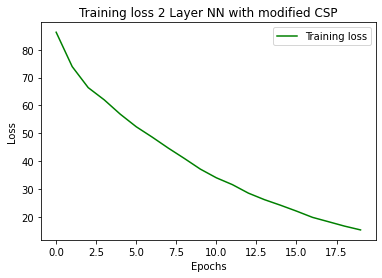

0.04902771624123178


In [342]:
epochs = range(0,num_epochs)
plt.plot(epochs, train_loss_list, 'g', label='Training loss')
plt.title('Training loss 2 Layer NN with modified CSP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(loss_val[20])

#### Section 4.3.1 CNN  Preparation <a class="anchor" id="sec3"></a>

In [21]:
from torch.utils.data import TensorDataset,DataLoader


In [22]:
# Hyper Parameters
input_size = 1000
n_channels = 3
num_classes = 2
learning_rate = 0.0004
batch_size = 4
num_epochs = 20

# Data Preparation train x
""" Converts the data to a 3D array by extracting values from each channel, the data is then scaled and passed
    into a dataloader. """
train_1d_cnn = train_x.to_numpy()
train_y_1d_cnn = train_y.values.astype(float)

train_list = []
for count, row in enumerate(train_1d_cnn):
    # Extract each channel 
    eeg1 = row[0] 
    eeg2 = row[1]
    eeg3 = row[2] 
    # Create output vector of (3,1000)
    eeg_stack = np.vstack((eeg1, eeg2))
    eeg_stack = np.vstack((eeg_stack, eeg3))
    train_list.append(eeg_stack)
    
# Combine the multiple training examples
train_2d = np.dstack(train_list)

# Change the shape
train_2d = train_2d.T

# Element 1 of the new shape will be 2 (Channels), Element 2 will be the the shape of the 
scaler = StandardScaler()
# Scale the data  - check the reshaping function to 2576000 x 3
train_2d_reshaped = train_2d.reshape(-1, train_2d.shape[-1])

# Scale the data then return to the original size
train_1d_cnn_scaled = scaler.fit_transform(train_2d.reshape(-1, train_2d.shape[-1])).reshape(train_2d.shape)


# Data Preparation test x
""" Converts the data to a 3D array by extracting values from each channel, the data is then scaled and passed
    into a dataloader. """
test_1d_cnn = test_x.to_numpy()
test_y_1d_cnn = test_y.values.astype(float)

test_list = []
for count, row in enumerate(test_1d_cnn):
    # Extract each channel 
    eeg1 = row[0] 
    eeg2 = row[1]
    eeg3 = row[2] 
    # Create output vector of (3,1000)
    eeg_stack = np.vstack((eeg1, eeg2))
    eeg_stack = np.vstack((eeg_stack, eeg3))
    test_list.append(eeg_stack)
    
# Combine the multiple training examples
test_2d = np.dstack(test_list)

# Change the shape
test_2d = test_2d.T
# Element 1 of the new shape will be 2 (Channels), Element 2 will be the the shape of the 
scaler = StandardScaler()
# Scale the data  - check the reshaping function to 2576000 x 3
test_2d_reshaped = test_2d.reshape(-1, test_2d.shape[-1])

# Scale the data then return to the original size
test_1d_cnn_scaled = scaler.fit_transform(test_2d.reshape(-1, test_2d.shape[-1])).reshape(test_2d.shape)



# Data Preparation val x
""" Converts the data to a 3D array by extracting values from each channel, the data is then scaled and passed
    into a dataloader. """
val_1d_cnn = val_x.to_numpy()
val_y_1d_cnn = val_y.values.astype(float)

val_list = []
for count, row in enumerate(val_1d_cnn):
    # Extract each channel 
    eeg1 = row[0] 
    eeg2 = row[1]
    eeg3 = row[2] 
    # Create output vector of (3,1000)
    eeg_stack = np.vstack((eeg1, eeg2))
    eeg_stack = np.vstack((eeg_stack, eeg3))
    val_list.append(eeg_stack)
    
# Combine the multiple training examples
val_2d = np.dstack(val_list)

# Change the shape
val_2d = val_2d.T

# Element 1 of the new shape will be 2 (Channels), Element 2 will be the the shape of the 
scaler = StandardScaler()
# Scale the data  - check the reshaping function to 2576000 x 3
val_2d_reshaped = val_2d.reshape(-1, val_2d.shape[-1])

# Scale the data then return to the original size
val_1d_cnn_scaled = scaler.fit_transform(val_2d.reshape(-1, val_2d.shape[-1])).reshape(val_2d.shape)


# Switch Axis for CNN input format of (Batch, Channel, Signal)

test_1d_cnn_scaled = test_1d_cnn_scaled.swapaxes(2,1)
train_1d_cnn_scaled = train_1d_cnn_scaled.swapaxes(2,1)
val_1d_cnn_scaled = val_1d_cnn_scaled.swapaxes(2,1)
print(test_1d_cnn_scaled.shape)
print(train_1d_cnn_scaled.shape)
print(val_1d_cnn_scaled.shape)

# Calling the Model (Test Version)
# INPUTS: train_1oader_cnn, test_1oader_cnn
# INPUTS FEATURES: train_1d_cnn_scaled, test_1d_cnn_scaled
# INPUTS LABELS: train_y_1d_cnn, test_y_1d_cnn
# INPUT SHAPE: trials, channels (3), length (1000)

train_features = torch.Tensor(train_1d_cnn_scaled)
test_features = torch.Tensor(test_1d_cnn_scaled)
val_features = torch.Tensor(val_1d_cnn_scaled)

print(train_features.shape)
print(test_features.shape)
print(val_features.shape)

print(val_y_1d_cnn.shape)
print(train_y_1d_cnn.shape)
print(test_y_1d_cnn.shape)

val_labels = torch.Tensor(val_y_1d_cnn)
train_labels = torch.Tensor(train_y_1d_cnn)
test_labels = torch.Tensor(test_y_1d_cnn)



(1104, 3, 1000)
(1932, 3, 1000)
(644, 3, 1000)
torch.Size([1932, 3, 1000])
torch.Size([1104, 3, 1000])
torch.Size([644, 3, 1000])
(644,)
(1932,)
(1104,)


#### Section 4.3.2 Designed 1D CNN <a class="anchor" id="sec3"></a>

- Batch Size: tested values 2,4,16,32,64,256,312. 16 Provided the highest Accuracy.
- Learning rate values tested of 0.01 0.001 0.0001
- Epoch Size: Validation Loss graph shows a region before noisey spikes i.e. consistent low loss..
- Originally it had 1 Linear output Layer, increased to 2 and then 3 as this provided the highest accuracy, ¾ showed little change, however having ⅔ linear layers varied by 9%.
- Added Max Pooling Layer
- Learning rate values tested of 0.01 0.001 0.0001
- 3 Channel input, expanded to 12 then reduced using pooling.
- Lower Loss when adding extra linears but didnt affect overall accuaracy
- When CSP applied the accuracy graph did not plateau before the original optimum epochs/data was able to train for longer
- CSP with +-5 Buffer gave an extra 1% test acc, but full range performed better
- Dropout increased ACC by 2%, added input and hidden layer dropout

Filtering Tried
CSP (4Hz) 63%
Mu Band (8-12Hz) 65%
Full Range (1-30Hz) 66%



In [120]:
# Implementation
class BCNN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=channels, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=12, out_channels=1, kernel_size=5, stride=2, padding=0)
        
        self.fc1 = nn.Linear(124, 62)
        self.fc2 = nn.Linear(62, 31)
        self.fc3 = nn.Linear(31, 1)
        self.flatten=nn.Flatten()
        
        self.dropoutIn = nn.Dropout(0.25)
        
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropoutIn(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 124)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # print(x.shape)
        # Softmax to be done on the loss function
        return x


In [121]:
# CNN testing
inputr = torch.randn(5, 3, 1000)
# Calling the Model (Test Version)
model = BCNN(3)
out = model(inputr)


In [127]:
# Hyper Parameters
n_channels = 3
num_classes = 1
learning_rate = 0.002
batch_size = 16
num_epochs = 7

model = BCNN(3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and Optimzer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

dataset = TensorDataset(val_features, val_labels)
val_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [128]:

min_valid_loss = np.inf
list_validation_loss = []
list_training_loss = []
list_training_acc = []
list_validation_acc = []


for e in range(num_epochs):
    correct = 0
    total = 0
    train_loss = 0.0
    correct_count = []
    total_count = []
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        # Loss
        target = model(data)
        target = torch.reshape(target, (-1,))
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Accuracy
        predicted = torch.sigmoid(target)
        predicted = predicted.reshape(-1).detach().numpy().round()
        labels = labels.numpy()
        total += labels.size
        correct += (predicted == labels).sum().item()

        

    acc = (100 * correct / total)
    print(correct)
    list_training_acc.append(acc)
    
    correct = 0
    total = 0
    valid_loss = 0.0
    # Set to eval mode
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in val_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        target = torch.reshape(target, (-1,))
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
        
        
        predicted = torch.sigmoid(target)
        predicted = predicted.reshape(-1).detach().numpy().round()
        labels = labels.numpy()
        total += labels.size
        correct += (predicted == labels).sum().item()
        
    val_acc = (100 * correct / total)
    list_validation_acc.append(val_acc)

    list_training_loss.append(train_loss / len(train_dataloader))  
    list_validation_loss.append(valid_loss / len(val_dataloader))

        
        

    print(f'Epoch {e+1} Training Acc: {acc} \t Training Loss: {train_loss / len(train_dataloader)} \t Validation Loss: {valid_loss / len(val_dataloader) }')

    
    # Will save the model with the lowest valdiation loss
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        



965
Epoch 1 Training Acc: 49.94824016563147 	 Training Loss: 0.6926631769858116 	 Validation Loss: 0.06650405395321729
Validation Loss Decreased(inf--->2.726666) 	 Saving The Model
1151
Epoch 2 Training Acc: 59.57556935817805 	 Training Loss: 0.6631415338555643 	 Validation Loss: 0.0619900924403493
Validation Loss Decreased(2.726666--->2.541594) 	 Saving The Model
1310
Epoch 3 Training Acc: 67.80538302277432 	 Training Loss: 0.6225586489212415 	 Validation Loss: 0.05097057761215582
Validation Loss Decreased(2.541594--->2.089794) 	 Saving The Model
1326
Epoch 4 Training Acc: 68.63354037267081 	 Training Loss: 0.5960563374452355 	 Validation Loss: 0.06138548618409692
1381
Epoch 5 Training Acc: 71.48033126293996 	 Training Loss: 0.5701935838076694 	 Validation Loss: 0.04237911177844536
Validation Loss Decreased(2.089794--->1.737544) 	 Saving The Model
1379
Epoch 6 Training Acc: 71.3768115942029 	 Training Loss: 0.5484342875559468 	 Validation Loss: 0.03784038671633092
Validation Loss Decr

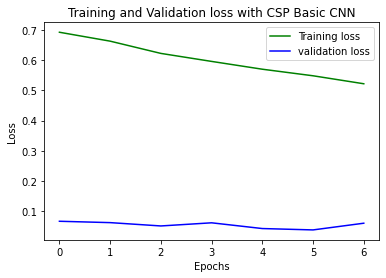

IndexError: list index out of range

In [129]:
loss_train = list_training_loss
loss_val = list_validation_loss
epochs = range(0,num_epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss with CSP Basic CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(loss_val[62])

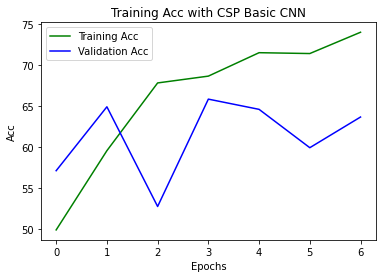

In [130]:
acc_train = list_training_acc
acc_validation = list_validation_acc

epochs = range(0,num_epochs)
plt.plot(epochs, acc_train, 'g', label='Training Acc')
plt.plot(epochs, acc_validation, 'b', label='Validation Acc')
plt.title('Training Acc with CSP Basic CNN')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [131]:
from torch.utils.data import TensorDataset,DataLoader
# Testing
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    training_accs = []
    testing_accs = []
    
    
    # Without calculating the gradients 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # print(outputs.data)

            # Sigmoid to restrict between 0 and 1
            predicted = torch.sigmoid(outputs)
            predicted = predicted.reshape(-1).detach().numpy().round()
            labels = labels.numpy()
            #print(predicted)
            #print(labels)

            total += labels.size
            correct += (predicted == labels).sum().item()
            
        print(f'Acc: {100 * correct // total} %')



print("Training Results")
check_accuracy(train_dataloader, model)
print("Test Results")
check_accuracy(test_dataloader, model)



Training Results
Acc: 76 %
Test Results
Acc: 66 %


#### Section 4.3.3  Academic Literature Inspired 1D CNN <a class="anchor" id="sec3"></a>

In [23]:
# Block definitions
class Block(nn.Module):
    def __init__(self, inchans):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=inchans, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=inchans, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=inchans, out_channels=32, kernel_size=8, stride=2, padding=3)
        self.relu= nn.ReLU()
        
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        # print(x1.shape, x2.shape, x3.shape)
        x = torch.cat([x1, x2, x3], dim=1)
        return x

# Block testing
inputr = torch.randn(5, 3, 1000)

# Block takes the number of channels
block = Block(3)
out1 = block(inputr)
out1.shape

block2 = Block(96)
out2 = block2(out1)
out2.shape

block3 = Block(96)
out3 = block3(out2)
out3.shape


torch.Size([5, 96, 125])

In [24]:
# Gated Recurrent Units
gru = nn.GRU(input_size=96, hidden_size=32, batch_first = True)
gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first = True)

# Permute the block output

x = out3.permute(0,2,1)

# Gru layers
gru_out1 , hnn = gru(x)
gru_out2 , hnn = gru2(gru_out1)
print(gru_out2.shape)


# Layers 1 & 2 concatenated
gru_out_cat1 = torch.cat([gru_out1, gru_out2], dim=2)

# Layers 1 & 2 feed into layer 3
gru3 = nn.GRU(input_size=64, hidden_size=32, batch_first = True)
gru_out3 , hnn = gru3(gru_out_cat1)

# Layer 3 concatenated with layer 1 and 2
gru_out_cat2 = torch.cat([gru_out1, gru_out2, gru_out3], dim=2)
print("yo")

# Output to length 32
print(gru_out_cat2.shape)
linear = nn.Linear(125, 1)
linear_out = linear(gru_out_cat2.permute(0,2,1))


gru4 = nn.GRU(input_size=96, hidden_size=32, batch_first=True)
gru_out4, hnn4 = gru4(linear_out.permute(0,2,1))
print(gru_out4.shape, hnn4.shape)



torch.Size([5, 125, 32])
yo
torch.Size([5, 125, 96])
torch.Size([5, 1, 32]) torch.Size([1, 5, 32])


In [25]:
%%capture
class CNN(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block1 = Block(channels)
        self.block2 = Block(96)
        self.block3 = Block(96)
        
        self.gru1 = nn.GRU(input_size=96, hidden_size=32, batch_first = True)
        self.gru2 = nn.GRU(input_size=32, hidden_size=32, batch_first = True)
        self.gru3 = nn.GRU(input_size=64, hidden_size=32, batch_first = True)
        self.gru4 = nn.GRU(input_size=96, hidden_size=32, batch_first = True)

        self.gru_linear = nn.Linear(125, 1)
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(32,1)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.permute(0,2,1)

        gru_out1, hn = self.gru1(x)
        gru_out2, hn = self.gru2(gru_out1)
        gru_out = torch.cat([gru_out1, gru_out2], dim=2)
        gru_out3 , hnn = self.gru3(gru_out)
        # Compress output of 3 for correct size for GRU4 input
        gru_out = torch.cat([gru_out1, gru_out2, gru_out3], dim=2)
        # print('Gru3/4 Shape:')
        # print(gru_out.shape)
        linear_out = self.relu(self.gru_linear(gru_out.permute(0,2,1)))
        gru_out4, hn = self.gru4(linear_out.permute(0,2,1))
        x = self.flatten(gru_out4)
        x = self.fc1(x)
        return x

        

In [26]:
# Calling the Model (Test Version)
model = CNN(3)
out = model(inputr)

# Output shape is 5,1 (1 value for each training example trial), as a random batch of 5 was used for testing
print(out.shape)
print(out)

torch.Size([5, 1])
tensor([[ 0.0010],
        [-0.0064],
        [-0.0019],
        [-0.0081],
        [ 0.0062]], grad_fn=<AddmmBackward0>)


Helpful course: https://www.udemy.com/course/deep-learning-with-pytorch/

In [27]:
from pytorch_lightning import LightningModule,Trainer
import torchmetrics
from torch.utils.data import TensorDataset,DataLoader
import torchmetrics

In [28]:
class CNNArch(LightningModule):
    def __init__(self):
        super(CNNArch,self).__init__()
        self.model=CNN(3)
        self.lr= 0.0007
        self.bs=16
        self.worker=2
        self.acc=torchmetrics.Accuracy()
        self.creterion=nn.BCEWithLogitsLoss()
        self.count = 0
        
        self.validation_accs_df = []
        self.training_accs_df = []

    def forward(self,x):
        x=self.model(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.lr)

    def train_dataloader(self):
        dataset=TensorDataset(train_features, train_labels)
        dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
        return dataloader

    def training_step(self,batch,batch_idx):
        signal,label=batch
        out=self(signal.float())
        loss=self.creterion(out.flatten(),label.float().flatten())
        acc=self.acc(out.flatten(),label.long().flatten())
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self,outputs):
        
        acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        print('Average train acc loss',acc,loss)
        self.training_accs_df.append(acc)
        epochs = range(len(self.training_accs_df))
        if self.count > 4:
            plt.plot(epochs, self.validation_accs_df, 'b', label='Validation Acc')
            plt.plot(epochs, self.training_accs_df, 'g', label='Training Acc')
            plt.title('Valdiation & Training Accuracy Academic CNN Lr:' + str(self.lr))
            plt.xlabel('Epochs')
            plt.ylabel('Acc')
            plt.legend()
            plt.show()

        

    def val_dataloader(self):
        dataset=TensorDataset(val_features,val_labels)
        dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
        return dataloader
    
    def validation_step(self,batch,batch_idx):
        signal,label=batch
        out=self(signal.float())
        loss=self.creterion(out.flatten(),label.float().flatten())
        acc=self.acc(out.flatten(),label.long().flatten())
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self,outputs):
        acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        print('Average validation acc loss',acc,loss)
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.logger.experiment.add_scalar('loss',avg_loss, self.current_epoch)
        if self.count > 0:
            self.validation_accs_df.append(acc)
        epochs = range(len(self.validation_accs_df))
        self.count += 1


        
    def test_dataloader(self):
        dataset=TensorDataset(test_features,test_labels)
        dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
        return dataloader
    
    def test_step(self,batch,batch_idx):
        signal,label=batch
        out=self(signal.float())
        loss=self.creterion(out.flatten(),label.float().flatten())
        acc=self.acc(out.flatten(),label.long().flatten())
        # print('test acc loss',acc,loss)
        return {'test loss':loss,'test acc':acc}
    
    def test_epoch_end(self,outputs):
        test_acc=torch.stack([x['test acc'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        test_loss=torch.stack([x['test loss'] for x in outputs]).mean().detach().cpu().numpy().round(2)
        print('Average Results: test acc loss',test_acc,test_loss)
       




In [32]:
model = CNNArch()
trainer = Trainer(max_epochs=8)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name      | Type              | Params
------------------------------------------------
0 | model     | CNN               | 128 K 
1 | acc       | Accuracy          | 0     
2 | creterion | BCEWithLogitsLoss | 0     
------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.514     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Average validation acc loss 0.5 0.69


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.59 0.63
Average train acc loss 0.52 0.69


Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.71 0.57
Average train acc loss 0.63 0.61


Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.62 0.6
Average train acc loss 0.68 0.56


Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.71 0.55
Average train acc loss 0.7 0.53


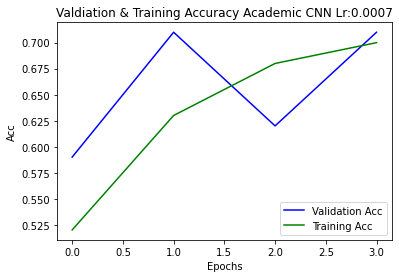

Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.67 0.57
Average train acc loss 0.75 0.5


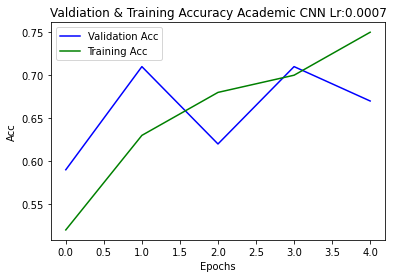

Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.71 0.55
Average train acc loss 0.75 0.49


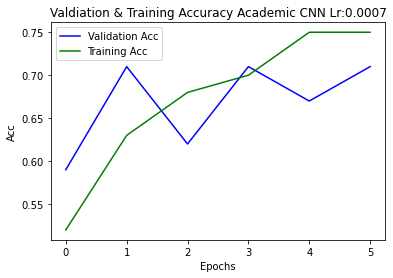

Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.71 0.57
Average train acc loss 0.75 0.49


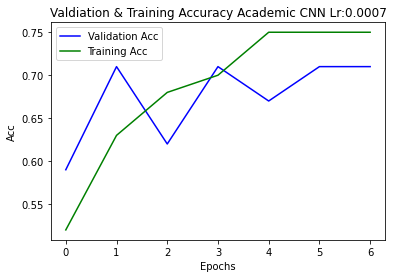

Validation: 0it [00:00, ?it/s]

Average validation acc loss 0.72 0.6
Average train acc loss 0.76 0.46


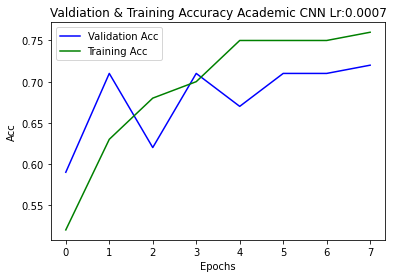

In [33]:
trainer.fit(model)

In [34]:
# using 8 epochs at max setting
trainer.test(model)

Testing: 0it [00:00, ?it/s]

Average Results: test acc loss 0.7 0.66


[{}]

In [31]:
# using 50 epochs at max setting
trainer.test(model)

/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Average Results: test acc loss 0.7 0.72


[{}]

#### Mu Rhythm CNN 8-13hz Evaluation 

#### Learning Rate 0.005

In [23]:

val_loss_mu = [0.69, 0.61, 0.58, 0.56, 0.57, 0.57, 0.57, 0.56, 0.6, 0.59, 0.59, 0.57, 0.58, 0.63, 0.61, 0.59, 0.6, 0.59, 0.62, 0.6, 0.61, 0.62, 0.61, 0.59, 0.59, 0.58, 0.62, 0.56, 0.61, 0.59, 0.6, 0.58, 0.58, 0.56, 0.57, 0.58, 0.59, 0.62, 0.57, 0.63, 0.58, 0.59, 0.64, 0.59, 0.59, 0.61, 0.61, 0.59, 0.6, 0.6, 0.59, 0.6, 0.59, 0.59, 0.57, 0.6, 0.6, 0.59, 0.58, 0.61, 0.59, 0.6, 0.59, 0.59, 0.59, 0.59, 0.6, 0.62, 0.62, 0.6, 0.6, 0.59, 0.62, 0.61, 0.6, 0.63, 0.6, 0.61, 0.61, 0.61, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.62, 0.61, 0.65, 0.65, 0.62, 0.61, 0.61, 0.62, 0.63, 0.59, 0.63, 0.61, 0.62, 0.63, 0.64, 0.64, 0.63, 0.66, 0.65, 0.65, 0.64, 0.65, 0.64, 0.64, 0.64, 0.65, 0.63, 0.63, 0.62, 0.63, 0.66, 0.64, 0.63, 0.65, 0.63, 0.65, 0.63, 0.65, 0.68, 0.64, 0.64, 0.63, 0.65, 0.64, 0.61, 0.61, 0.63, 0.62, 0.64, 0.63, 0.65, 0.62, 0.61, 0.65, 0.64, 0.62, 0.65, 0.67, 0.67, 0.62, 0.63, 0.65, 0.61, 0.61, 0.62, 0.62, 0.61, 0.61, 0.63, 0.62, 0.63, 0.66, 0.69, 0.68, 0.66, 0.64, 0.65, 0.6, 0.63, 0.66, 0.67, 0.68, 0.66, 0.68, 0.66, 0.67, 0.66, 0.68, 0.68, 0.69, 0.73, 0.72, 0.73, 0.67, 0.7, 0.73, 0.69, 0.69, 0.68, 0.68, 0.64, 0.66, 0.7, 0.72, 0.71, 0.77, 0.76, 0.72, 0.8, 0.76, 0.76, 0.76, 0.76, 0.75, 0.76, 0.79, 0.71, 0.77, 0.73, 0.74, 0.73, 0.71, 0.75, 0.73, 0.75, 0.82, 0.76, 0.8, 0.79, 0.79, 0.75, 0.78, 0.73, 0.67, 0.7, 0.66, 0.66, 0.65, 0.66, 0.67, 0.65, 0.65, 0.67, 0.66, 0.68, 0.68, 0.71, 0.67, 0.7, 0.7, 0.66, 0.71, 0.7, 0.7, 0.64, 0.7, 0.69, 0.7, 0.7, 0.68, 0.7, 0.72, 0.73, 0.69]
val_acc_mu = [0.51, 0.59, 0.65, 0.68, 0.69, 0.63, 0.65, 0.69, 0.63, 0.67, 0.67, 0.69, 0.62, 0.6, 0.65, 0.64, 0.65, 0.65, 0.63, 0.63, 0.62, 0.65, 0.63, 0.66, 0.64, 0.66, 0.58, 0.64, 0.61, 0.64, 0.63, 0.65, 0.65, 0.66, 0.64, 0.68, 0.64, 0.61, 0.68, 0.58, 0.68, 0.66, 0.64, 0.66, 0.68, 0.64, 0.65, 0.65, 0.65, 0.66, 0.66, 0.64, 0.65, 0.66, 0.69, 0.65, 0.67, 0.66, 0.68, 0.63, 0.66, 0.63, 0.66, 0.64, 0.62, 0.64, 0.62, 0.65, 0.64, 0.63, 0.62, 0.65, 0.65, 0.62, 0.66, 0.6, 0.65, 0.62, 0.61, 0.63, 0.64, 0.64, 0.64, 0.65, 0.65, 0.64, 0.62, 0.64, 0.62, 0.62, 0.62, 0.63, 0.65, 0.66, 0.64, 0.65, 0.62, 0.65, 0.6, 0.66, 0.64, 0.63, 0.61, 0.62, 0.61, 0.62, 0.62, 0.59, 0.62, 0.62, 0.61, 0.62, 0.62, 0.62, 0.64, 0.62, 0.61, 0.63, 0.64, 0.61, 0.61, 0.63, 0.62, 0.61, 0.62, 0.62, 0.64, 0.64, 0.62, 0.62, 0.64, 0.64, 0.61, 0.62, 0.64, 0.62, 0.61, 0.64, 0.64, 0.62, 0.62, 0.65, 0.59, 0.63, 0.62, 0.64, 0.66, 0.63, 0.65, 0.65, 0.65, 0.64, 0.68, 0.66, 0.65, 0.64, 0.66, 0.63, 0.62, 0.66, 0.66, 0.65, 0.64, 0.68, 0.65, 0.67, 0.64, 0.65, 0.61, 0.66, 0.63, 0.65, 0.68, 0.64, 0.63, 0.64, 0.61, 0.59, 0.61, 0.65, 0.63, 0.59, 0.64, 0.6, 0.64, 0.62, 0.66, 0.64, 0.64, 0.64, 0.62, 0.61, 0.61, 0.63, 0.62, 0.6, 0.6, 0.61, 0.63, 0.62, 0.6, 0.59, 0.61, 0.56, 0.58, 0.58, 0.6, 0.61, 0.62, 0.62, 0.63, 0.57, 0.59, 0.6, 0.63, 0.63, 0.61, 0.59, 0.56, 0.6, 0.55, 0.59, 0.58, 0.6, 0.6, 0.57, 0.58, 0.61, 0.6, 0.59, 0.61, 0.6, 0.59, 0.59, 0.56, 0.58, 0.6, 0.57, 0.58, 0.58, 0.59, 0.55, 0.57, 0.56, 0.58, 0.61, 0.59, 0.57, 0.6, 0.61]
train_loss_mu = [0.69, 0.66, 0.6, 0.58, 0.59, 0.57, 0.58, 0.56, 0.56, 0.57, 0.56, 0.56, 0.55, 0.56, 0.56, 0.57, 0.55, 0.56, 0.56, 0.54, 0.58, 0.57, 0.57, 0.56, 0.56, 0.56, 0.58, 0.57, 0.55, 0.55, 0.56, 0.56, 0.56, 0.57, 0.56, 0.55, 0.56, 0.54, 0.56, 0.57, 0.56, 0.56, 0.56, 0.56, 0.54, 0.54, 0.54, 0.57, 0.57, 0.55, 0.55, 0.56, 0.55, 0.53, 0.54, 0.56, 0.57, 0.56, 0.56, 0.56, 0.55, 0.56, 0.55, 0.54, 0.56, 0.54, 0.54, 0.54, 0.55, 0.57, 0.56, 0.55, 0.55, 0.55, 0.55, 0.55, 0.56, 0.55, 0.57, 0.56, 0.57, 0.56, 0.54, 0.54, 0.55, 0.54, 0.54, 0.54, 0.54, 0.57, 0.58, 0.55, 0.54, 0.53, 0.51, 0.52, 0.51, 0.54, 0.55, 0.52, 0.51, 0.51, 0.5, 0.5, 0.51, 0.51, 0.52, 0.55, 0.55, 0.58, 0.56, 0.55, 0.56, 0.55, 0.55, 0.54, 0.53, 0.54, 0.54, 0.54, 0.54, 0.53, 0.55, 0.56, 0.54, 0.55, 0.54, 0.55, 0.53, 0.55, 0.55, 0.55, 0.53, 0.52, 0.53, 0.54, 0.54, 0.58, 0.56, 0.53, 0.53, 0.51, 0.5, 0.5, 0.52, 0.53, 0.5, 0.49, 0.52, 0.51, 0.48, 0.51, 0.49, 0.5, 0.47, 0.49, 0.48, 0.47, 0.45, 0.46, 0.45, 0.5, 0.48, 0.49, 0.46, 0.49, 0.47, 0.45, 0.46, 0.47, 0.48, 0.5, 0.48, 0.46, 0.47, 0.5, 0.48, 0.52, 0.52, 0.51, 0.49, 0.51, 0.5, 0.5, 0.48, 0.47, 0.47, 0.46, 0.45, 0.41, 0.43, 0.47, 0.48, 0.45, 0.44, 0.43, 0.42, 0.46, 0.43, 0.43, 0.44, 0.48, 0.47, 0.48, 0.5, 0.51, 0.49, 0.47, 0.44, 0.43, 0.46, 0.42, 0.43, 0.43, 0.41, 0.42, 0.45, 0.48, 0.53, 0.58, 0.55, 0.58, 0.6, 0.58, 0.57, 0.56, 0.58, 0.55, 0.54, 0.54, 0.52, 0.54, 0.54, 0.53, 0.56, 0.55, 0.56, 0.55, 0.56, 0.53, 0.57, 0.56, 0.54, 0.53, 0.52, 0.52, 0.52, 0.48, 0.51, 0.5]
train_acc_mu = [0.5, 0.55, 0.64, 0.66, 0.65, 0.68, 0.66, 0.68, 0.68, 0.67, 0.68, 0.68, 0.69, 0.67, 0.68, 0.67, 0.69, 0.68, 0.69, 0.7, 0.65, 0.67, 0.68, 0.67, 0.68, 0.68, 0.67, 0.67, 0.7, 0.68, 0.69, 0.67, 0.68, 0.67, 0.68, 0.68, 0.68, 0.7, 0.69, 0.69, 0.68, 0.69, 0.68, 0.68, 0.7, 0.7, 0.7, 0.67, 0.67, 0.68, 0.7, 0.68, 0.68, 0.7, 0.7, 0.69, 0.67, 0.68, 0.68, 0.67, 0.68, 0.67, 0.67, 0.69, 0.67, 0.69, 0.69, 0.69, 0.68, 0.67, 0.67, 0.68, 0.69, 0.69, 0.68, 0.69, 0.67, 0.69, 0.67, 0.67, 0.68, 0.69, 0.71, 0.7, 0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.67, 0.68, 0.69, 0.71, 0.72, 0.72, 0.72, 0.69, 0.7, 0.71, 0.72, 0.72, 0.73, 0.74, 0.74, 0.72, 0.72, 0.69, 0.69, 0.67, 0.68, 0.68, 0.69, 0.7, 0.69, 0.7, 0.69, 0.71, 0.7, 0.7, 0.7, 0.7, 0.69, 0.68, 0.7, 0.7, 0.71, 0.7, 0.71, 0.7, 0.69, 0.69, 0.71, 0.71, 0.7, 0.7, 0.7, 0.66, 0.68, 0.69, 0.71, 0.72, 0.73, 0.73, 0.73, 0.7, 0.73, 0.74, 0.71, 0.72, 0.74, 0.74, 0.75, 0.73, 0.76, 0.73, 0.74, 0.75, 0.77, 0.77, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.76, 0.77, 0.77, 0.76, 0.75, 0.74, 0.76, 0.77, 0.76, 0.74, 0.75, 0.73, 0.7, 0.72, 0.74, 0.72, 0.74, 0.74, 0.74, 0.77, 0.76, 0.77, 0.77, 0.79, 0.78, 0.76, 0.75, 0.78, 0.79, 0.78, 0.79, 0.77, 0.77, 0.78, 0.78, 0.74, 0.75, 0.74, 0.74, 0.73, 0.74, 0.76, 0.78, 0.78, 0.76, 0.79, 0.77, 0.79, 0.8, 0.78, 0.78, 0.74, 0.72, 0.67, 0.69, 0.65, 0.64, 0.64, 0.68, 0.68, 0.66, 0.7, 0.7, 0.69, 0.71, 0.71, 0.71, 0.71, 0.68, 0.69, 0.69, 0.69, 0.67, 0.71, 0.67, 0.68, 0.7, 0.7, 0.71, 0.7, 0.72, 0.74, 0.72, 0.74]

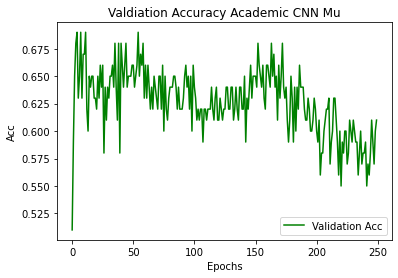

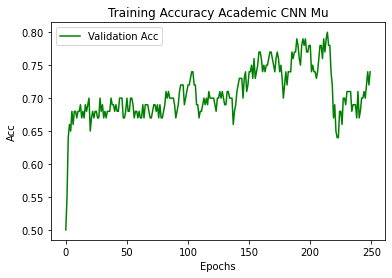

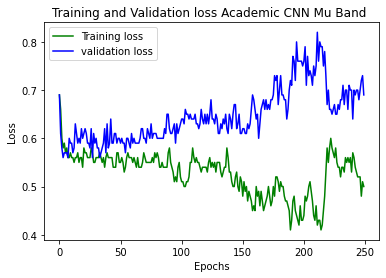

NameError: name 'acc_train' is not defined

In [24]:

epochs = range(250)
plt.plot(epochs, val_acc_mu, 'g', label='Validation Acc')
plt.title('Valdiation Accuracy Academic CNN Mu')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

epochs = range(250)
plt.plot(epochs, train_acc_mu, 'g', label='Validation Acc')
plt.title('Training Accuracy Academic CNN Mu')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


epochs = range(250)
plt.plot(epochs, train_loss_mu, 'g', label='Training loss')
plt.plot(epochs, val_loss_mu , 'b', label='validation loss')
plt.title('Training and Validation loss Academic CNN Mu Band ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


max_value = max(acc_train)
print(max_value)
print(acc_train.index(max_value))

In [381]:
min_value = min(list_val_loss)
print(list_val_loss.index(min_value))
print(list_val_loss[4])

4
0.56


#### Learning rate 0.0005

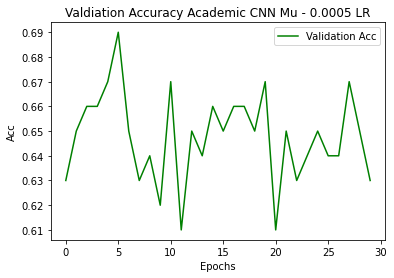

In [27]:
val_acc_improv1 = [0.63, 0.65, 0.66, 0.66, 0.67, 0.69, 0.65, 0.63, 0.64, 0.62, 0.67, 0.61, 0.65, 0.64, 0.66, 0.65, 0.66, 0.66, 0.65, 0.67, 0.61, 0.65, 0.63, 0.64, 0.65, 0.64, 0.64, 0.67, 0.65, 0.63]

epochs = range(30)
plt.plot(epochs, val_acc_improv1, 'g', label='Validation Acc')
plt.title('Valdiation Accuracy Academic CNN Mu - 0.0005 LR')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()




#### All Rhythms 1-30Hz Evaluation

In [409]:
train_loss_all = [0.5, 0.57, 0.63, 0.69, 0.71, 0.71, 0.74, 0.75, 0.76, 0.77, 0.77, 0.78, 0.79, 0.78, 0.8, 0.8, 0.8, 0.81, 0.81, 0.82, 0.82, 0.84, 0.83, 0.8, 0.82, 0.82, 0.83, 0.83, 0.84, 0.86, 0.84, 0.86, 0.88, 0.84, 0.84, 0.86, 0.86, 0.85, 0.86, 0.87, 0.87, 0.89, 0.88, 0.87, 0.88, 0.87, 0.84, 0.87, 0.88, 0.91, 0.91, 0.88, 0.87, 0.88, 0.88, 0.89, 0.89, 0.89, 0.88, 0.85, 0.87, 0.87, 0.9]
val_loss_all = [0.68, 0.6, 0.58, 0.58, 0.58, 0.59, 0.57, 0.57, 0.59, 0.57, 0.62, 0.6, 0.61, 0.59, 0.66, 0.59, 0.6, 0.59, 0.68, 0.66, 0.58, 0.63, 0.65, 0.61, 0.6, 0.6, 0.71, 0.63, 0.65, 0.66, 0.69, 0.72, 0.72, 0.72, 0.66, 0.66, 0.73, 0.7, 0.68, 0.73, 0.72, 0.82, 0.77, 0.76, 0.8, 0.8, 0.71, 0.74, 0.79, 0.85, 0.81, 0.83, 0.82, 0.79, 0.79, 0.75, 0.78, 0.82, 0.94, 0.81, 0.73, 0.74, 0.79]
val_acc_all = [0.53, 0.69, 0.67, 0.69, 0.69, 0.66, 0.69, 0.7, 0.65, 0.72, 0.66, 0.67, 0.69, 0.7, 0.67, 0.71, 0.69, 0.71, 0.66, 0.71, 0.7, 0.71, 0.68, 0.69, 0.74, 0.73, 0.7, 0.7, 0.69, 0.73, 0.67, 0.69, 0.69, 0.7, 0.7, 0.71, 0.7, 0.7, 0.71, 0.68, 0.69, 0.67, 0.66, 0.68, 0.71, 0.7, 0.69, 0.7, 0.69, 0.7, 0.71, 0.67, 0.66, 0.69, 0.67, 0.7, 0.71, 0.68, 0.66, 0.67, 0.69, 0.69, 0.71]

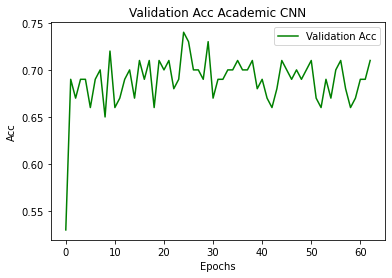

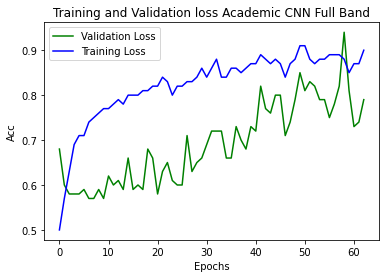

In [410]:
epochs = range(63)
plt.plot(epochs, val_acc_all, 'g', label='Validation Acc')
plt.title('Validation Acc Academic CNN')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

epochs = range(63)
plt.plot(epochs, val_loss_all, 'g', label='Validation Loss')
plt.plot(epochs, train_loss_all, 'b', label='Training Loss')
plt.title('Training and Validation loss Academic CNN Full Band')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


#### CSP Evaluation

Average Results: test acc loss 0.68 0.69

In [439]:
val_acc_csp = [0.51, 0.64, 0.62, 0.7, 0.63, 0.69, 0.7, 0.73, 0.68, 0.7, 0.69, 0.71, 0.71, 0.71, 0.66, 0.7, 0.7, 0.72, 0.71, 0.7, 0.72, 0.72, 0.73, 0.71, 0.69, 0.72, 0.68, 0.71, 0.73, 0.72, 0.73, 0.72, 0.74, 0.71, 0.69, 0.7, 0.72, 0.73, 0.72, 0.74, 0.71, 0.72, 0.73, 0.71, 0.72, 0.7, 0.68, 0.71, 0.7, 0.69, 0.7, 0.7, 0.72, 0.73, 0.71, 0.72, 0.69, 0.71, 0.69, 0.7, 0.7, 0.73, 0.7]
val_loss_csp = [0.69, 0.67, 0.59, .58, 0.57, 0.56, 0.55, 0.55, 0.57, .56, 0.57, 0.59, 0.63, 0.58, 0.63, .58, 0.65, 0.56, 0.58, .69, 0.59, 0.61, 0.58, 0.59, 0.63, 0.63, 0.68, 0.66, 0.6, 0.58, 0.6, 0.6, 0.65, 0.62, 0.71, .65, 0.64, 0.57, 0.65, 0.67, 0.64, 0.63, 0.6, 0.64, 0.66, .75, 0.76, 0.65, .65, 0.72, .66, .71, 0.68, 0.67, 0.7, 0.77, 0.75, 0.73, 0.77, 0.69, 0.7, 0.73, .73]

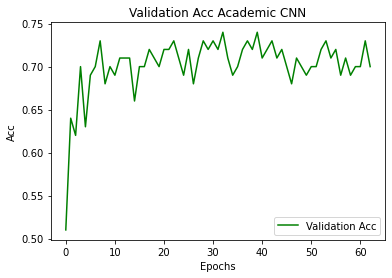

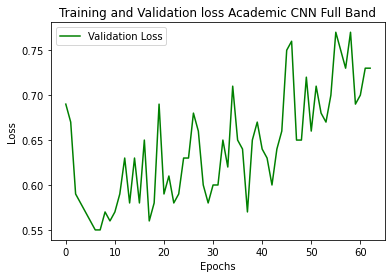

0.74
32


In [444]:
epochs = range(63)
plt.plot(epochs, val_acc_csp, 'g', label='Validation Acc')
plt.title('Validation Acc Academic CNN')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

epochs = range(63)
plt.plot(epochs, val_loss_csp, 'g', label='Validation Loss')
plt.title('Training and Validation loss Academic CNN Full Band')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

max_value = max(val_acc_csp)
print(max_value)
print(val_acc_csp.index(max_value))